### Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(rc = {'figure.figsize':(4,4)}, font_scale=0.8)
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder 
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

### Read Dataset

In [2]:
df = pd.read_csv('../Data/insurance_data.csv', sep = ';')

In [3]:
df.head(5)

,insuree#,gender,is45OrOlder,isMarried,hasKids,insuredMonths,termLifeInsurance,multipleTermLifePolicies,healthInsurance,healthRiders,premiumFrequency,eStatements,monthlyPremium,totalPremium,renewal
0,1,F,0.0,Yes,Yes,23,Yes,No,No,NaN,12.0,Yes,"19,65","451,55",Y
1,2,F,1.0,No,No,42,Yes,Yes,Class A,3,1.0,Yes,"84,65","3541,35",N
2,3,F,0.0,Yes,No,72,Yes,No,No,NaN,12.0,No,"19,4","1496,45",Y
3,4,F,0.0,Yes,Yes,13,Yes,No,No,NaN,12.0,No,"19,55","265,3",Y
4,5,F,0.0,No,No,37,Yes,Yes,Class A,"3,4",1.0,No,"100,3","3541,4",Y


### Preprocess Data

Target for prediction is created with the following assumption: Assuming that the insurance company wants to identify customers who are likely to not renew in order to follow up with them to target and retain them, the positive class in this binary classification problem is the insurees who did not renew while the negative class is the insurees who did renew. 

Categorical variables with cardinality of 2 possible values are converted into binary variables with values 0 and 1. For example, 'No' in isMarried is mapped to 0 to indicate that an insuree is not married while 'Yes' in isMarried is mapped to 1 to indicate that an insuree is married.

Numerical features, monthlyPremium and totalPremium is cleaned to replace ',' with '.' and converted into float. 

A new feature termLifePolicy is created from termLifeInsurance and multipleTermLifePolicies by representing the information in these 2 features in 1 feature. termLifePolicy has 3 possible values: 'no' to indicate insuree does not have any term life policy, 'single' to indicate insuree only has 1 term life policy and 'multiple' to indicate that insuree has multiple term life policies. To better understand why this was done, refer to eda.ipynb for the exploratory data analysis and observations. 

4 new features (healthRider1, healthRider2, healthRider3, healthRider4) are created as binary variables with values 0 and 1. For example, 0 in healthRider1 indicates that insuree has healthRider 1 while 1 in healthRider1 indicates that insuree does not have healthRider 1.

After the above preprocessing steps, columns that are redundant are dropped. insuree# is dropped as it is a unique identifier and should not be used as a feature in building a predictive model.

In [4]:
df['target'] = df['renewal'].map({'N': 1, 'Y': 0})
df['isMarried'] = df['isMarried'].map({'No': 0, 'Yes': 1})
df['isMale'] = df['gender'].map({'F': 0, 'M': 1})
df['hasKids'] = df['hasKids'].map({'No': 0, 'Yes': 1})
df['eStatements'] = df['eStatements'].map({'No': 0, 'Yes': 1})

df['monthlyPremium'] = df['monthlyPremium'].str.replace(',', '.').astype(float)
df['totalPremium'] = df['totalPremium'].str.replace(',', '.').str.strip().apply(lambda x: float(x) if len(x) != 0 else np.nan)

df['termLifePolicy'] = np.where(df['termLifeInsurance'] == 'No', 'no', 
                                np.where(df['multipleTermLifePolicies'] == 'Yes', 'multiple',
                                'single'
                                ))

for i in range(1, 5):
    df[f'healthRider{i}'] = df['healthRiders'].str.contains('3', regex=False).astype(float)

df.drop(columns=['insuree#', 'renewal', 'termLifeInsurance', 'multipleTermLifePolicies', 'healthRiders', 'gender'], inplace=True)

### Train-test Split

To simulate how the model built will perform with new data, a train test split is used to create a train set that is 80% of the entire dataset for the model to learn from and a test set that is 20% of the entire dataset to be used to evaluate the model's performance. Random state is set to 42 for reproducibility. 

In [5]:
X = df.drop(columns='target')
y = df['target']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Train set dimensions: {X_train.shape}')
print(f'Test set dimensions: {X_test.shape}')

Train set dimensions: (4400, 15)
Test set dimensions: (1100, 15)


Distribution of the target variable is checked. There is no heavy imbalance observed.

In [6]:
y_train.value_counts(normalize=True)

0    0.734318
1    0.265682
Name: target, dtype: float64

### Treat categorical features

One Hot Encoding is used to convert the categorical features, healthInsurance and termLifePolicy into numerical features without dropping one of the categories per feature. This is because the downstream models used such as logistic regression with regularisation and tree-based models are not affected by the dummy variable trap and dropping a category can induce bias instead by breaking the symmetry of the original representation.

In [7]:
enc = OneHotEncoder(categories='auto')
features_ohe_train = enc.fit_transform(X_train[['healthInsurance', 'termLifePolicy']])
features_ohe_test = enc.transform(X_test[['healthInsurance', 'termLifePolicy']])

In [8]:
features_to_drop = ['healthInsurance', 'termLifePolicy']
OHE_train = np.hstack((X_train.drop(features_to_drop, axis=1).values, features_ohe_train.toarray()))
OHE_test = np.hstack((X_test.drop(features_to_drop, axis=1).values, features_ohe_test.toarray()))

In [9]:
print(f'Train set dimensions: {OHE_train.shape}')
print(f'Test set dimensions: {OHE_test.shape}')

Train set dimensions: (4400, 19)
Test set dimensions: (1100, 19)


### Impute missing values

With the discovery of missing values in eda.ipynb, imputation for completing missing values is done using k-Nearest Neighbors with k = 3. Missing values of each sample are imputed using the mean value from 3 nearest neighbors found in the training set.

In [10]:
print(f'{np.isnan(OHE_train).sum()} missing values in Train set')
print(f'{np.isnan(OHE_test).sum()} missing values in Test set')

6595 missing values in Train set
1665 missing values in Test set


In [11]:
imputer = KNNImputer(n_neighbors=3)
imputed_train = imputer.fit_transform(OHE_train)
imputed_test = imputer.transform(OHE_test)

In [12]:
print(f'{np.isnan(imputed_train).sum()} missing values in Train set')
print(f'{np.isnan(imputed_test).sum()} missing values in Test set')

0 missing values in Train set
0 missing values in Test set


In [13]:
print(f'Train set dimensions: {imputed_train.shape}')
print(f'Test set dimensions: {imputed_test.shape}')

Train set dimensions: (4400, 19)
Test set dimensions: (1100, 19)


### Helper Functions to Evaluate Model Performance

In [14]:
def plot_confusion_matrix(cm):
  classes = ['No-Renew', 'Renew']
  ax = sns.heatmap(cm, cmap="Blues", annot=True, xticklabels=classes, yticklabels=classes, cbar=False,fmt='.5g')
  ax.set(title="Confusion Matrix", xlabel="Predicted Label", ylabel="Actual Label")
  plt.show()

In [15]:
def print_metrics(y_true, y_pred, y_pred_prob):
    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    array_cm = np.array([[TP, FN], [FP, TN]])
    plot_confusion_matrix(array_cm)
    
    print("F1 Score:", f1_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred)) 
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("ROC AUC:", roc_auc_score(y_true, y_pred_prob))

### Build baseline model, Logistic Regression

Logistic regression with l2 Regularization is used as the baseline for comparison with other models. Since logistic regression is affected by the scale of the features, I scale all features by removing the median and scale the data according to the Interquartile Range. The choice of RobustScaler is due to the outliers that were detected in doing Exploratory Data Analysis, but kept as further investigation seems to show that they are true observations.

Random state is set to 42 for all models for reproducibility.

In [16]:
scaler = RobustScaler()
scaled_train = scaler.fit_transform(imputed_train)
scaled_test = scaler.transform(imputed_test)

In [17]:
logreg = LogisticRegression(solver='liblinear', random_state=42)
logreg.fit(scaled_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

#### Performance of Logistic Regression on Train Set

Confusion Matrix


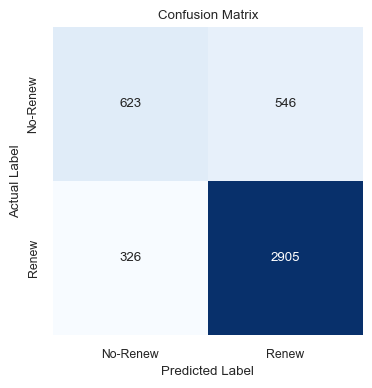

F1 Score: 0.5882908404154864
Precision: 0.6564805057955743
Recall: 0.5329341317365269
Accuracy: 0.8018181818181818
ROC AUC: 0.8420846329624873


In [18]:
pred_train = logreg.predict(scaled_train)
pred_prob_train = logreg.predict_proba(scaled_train)[:, 1]
print_metrics(y_train, pred_train, pred_prob_train)

#### Performance of Logistic Regression on Test Set

Confusion Matrix


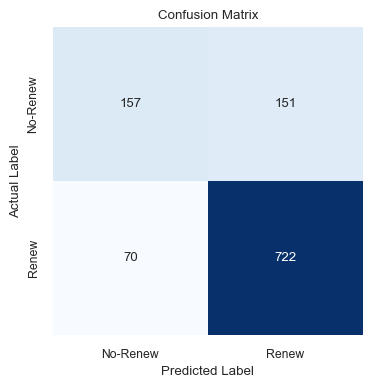

F1 Score: 0.5869158878504673
Precision: 0.6916299559471366
Recall: 0.5097402597402597
Accuracy: 0.7990909090909091
ROC AUC: 0.8329315886134068


In [19]:
pred_test = logreg.predict(scaled_test)
pred_prob_test = logreg.predict_proba(scaled_test)[:, 1]
print_metrics(y_test, pred_test, pred_prob_test)

### Build alternative model, Decision Tree 

Decision Tree Classifier is attempted with 20 as the minimum number of samples required to split an internal node. This is to avoid fully grown and unpruned trees that lead to overfitting. This hyperparameter value is used for all other tree-based approaches tried for a clearer comparison between the approaches. 

In [20]:
dt_estimator = DecisionTreeClassifier(min_samples_split=20, random_state=42)
dt_estimator.fit(imputed_train, y_train)

DecisionTreeClassifier(min_samples_split=20, random_state=42)

#### Performance of Decision Tree Classifier on Train Set

Confusion Matrix


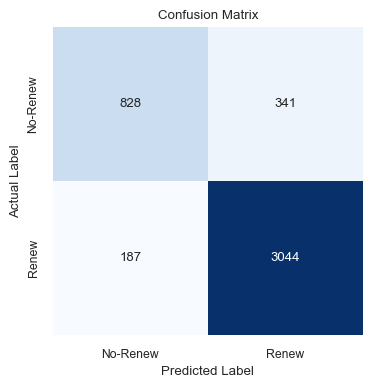

F1 Score: 0.7582417582417582
Precision: 0.8157635467980295
Recall: 0.7082976903336184
Accuracy: 0.88
ROC AUC: 0.9462033619456934


In [21]:
dt_pred_train = dt_estimator.predict(imputed_train)
dt_pred_prob_train = dt_estimator.predict_proba(imputed_train)[:, 1]
print_metrics(y_train, dt_pred_train, dt_pred_prob_train)

#### Performance of Decision Tree Classifier on Test Set

Confusion Matrix


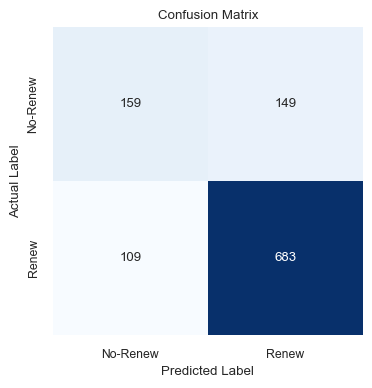

F1 Score: 0.5520833333333334
Precision: 0.5932835820895522
Recall: 0.5162337662337663
Accuracy: 0.7654545454545455
ROC AUC: 0.7714113537977174


In [22]:
dt_pred_test = dt_estimator.predict(imputed_test)
dt_pred_prob_test = dt_estimator.predict_proba(imputed_test)[:, 1]
print_metrics(y_test, dt_pred_test, dt_pred_prob_test)

### Build alternative model, Random Forest

Random Forest is attempted with 20 as the minimum number of samples required to split an internal node. This is to avoid fully grown and unpruned trees that lead to overfitting. This hyperparameter value is used for all other tree-based approaches tried for a clearer comparison between the approaches. 

In [23]:
rf_estimator = RandomForestClassifier(min_samples_split=20, random_state=42)
rf_estimator.fit(imputed_train, y_train)

RandomForestClassifier(min_samples_split=20, random_state=42)

#### Performance of Random Forest Classifier on Train Set

Confusion Matrix


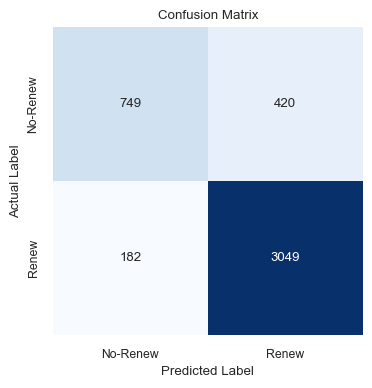

F1 Score: 0.7133333333333333
Precision: 0.8045112781954887
Recall: 0.6407185628742516
Accuracy: 0.8631818181818182
ROC AUC: 0.9332994708288688


In [24]:
rf_pred_train = rf_estimator.predict(imputed_train)
rf_pred_prob_train = rf_estimator.predict_proba(imputed_train)[:, 1]
print_metrics(y_train, rf_pred_train, rf_pred_prob_train)

#### Performance of Random Forest Classifier on Test Set

Confusion Matrix


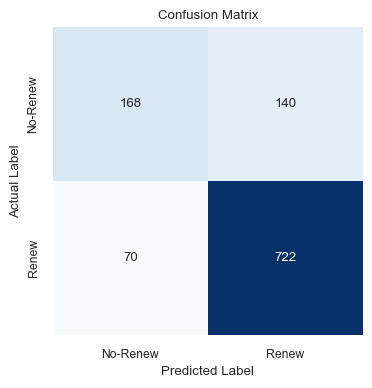

F1 Score: 0.6153846153846153
Precision: 0.7058823529411765
Recall: 0.5454545454545454
Accuracy: 0.8090909090909091
ROC AUC: 0.8448240522104158


In [25]:
rf_pred_test = rf_estimator.predict(imputed_test)
rf_pred_prob_test = rf_estimator.predict_proba(imputed_test)[:, 1]
print_metrics(y_test, rf_pred_test, rf_pred_prob_test)

### Build alternative model, GradientBoostingClassifier

Gradient Boosting Classifier is attempted with 20 as the minimum number of samples required to split an internal node. This is to avoid fully grown and unpruned trees that lead to overfitting. This hyperparameter value is used for all other tree-based approaches tried for a clearer comparison between the approaches. 

In [50]:
gb_estimator = GradientBoostingClassifier(min_samples_split=20, random_state=42)
gb_estimator.fit(imputed_train, y_train)

GradientBoostingClassifier(min_samples_split=20, random_state=42)

#### Performance of Gradient Boosting Classifier on Train Set

Confusion Matrix


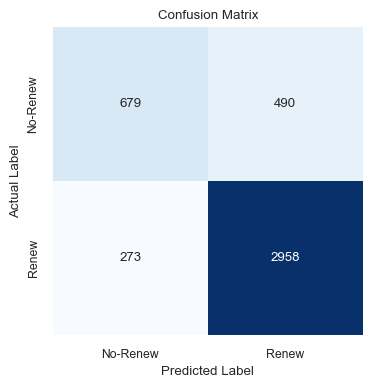

F1 Score: 0.6402640264026402
Precision: 0.7132352941176471
Recall: 0.5808383233532934
Accuracy: 0.826590909090909
ROC AUC: 0.8813856568597783


In [51]:
gb_pred_train = gb_estimator.predict(imputed_train)
gb_pred_prob_train = gb_estimator.predict_proba(imputed_train)[:, 1]
print_metrics(y_train, gb_pred_train, gb_pred_prob_train)

#### Performance of Gradient Boosting Classifier on Test Set

Confusion Matrix


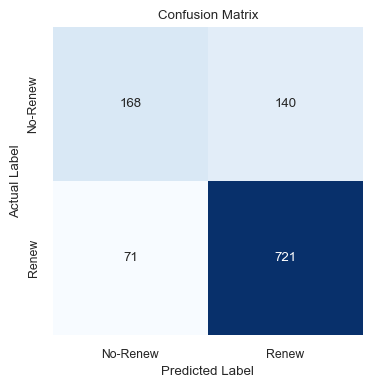

F1 Score: 0.6142595978062156
Precision: 0.702928870292887
Recall: 0.5454545454545454
Accuracy: 0.8081818181818182
ROC AUC: 0.8445616883116882


In [52]:
gb_pred_test = gb_estimator.predict(imputed_test)
gb_pred_prob_test = gb_estimator.predict_proba(imputed_test)[:, 1]
print_metrics(y_test, gb_pred_test, gb_pred_prob_test)

### Comparison of Model Performances on Test Set

| Model | F1 Score | 
| :- | :- |
| Logistic Regression | 0.587 |
| Decision Tree Classifier | 0.552 |
| Random Forest Classifier | 0.615 | 
| Gradient Boosting Classifier | 0.614 |

Logistic Regression and tree-based models are attempted due to the need for explainability in order to identify the most important factors that contribute to why the insurees are not renewing. 

The model that has the highest F1 score is Random Forest Classifier. In the interest of time, hyperparameter tuning is done using a randomised search to find the best set of hyperparameters for Random Forest Classifier only. 

The choice of using F1 score as the main evaluation metric is due to the importance of precision and recall to the insurance company. From the company's perspective, it is important to identify insurees who do not renew in order to target and retain their customers. Hence, a high precision is preferred as it is crucial for the company to correctly identify insurees who do not renew out of those predicted to not renew in order to not waste resources targetting insurees who will renew even without any actions by the company. On the other hand, a high recall is also preferred as it is crucial for the company to identify as much insurees who do not renew out of all insurees who actually do not renew so that the number of relevant insurees identified are maximised and targeted. Since F1 score is the harmonic mean of precision and recall, as well as the slight imbalance in the dataset with lesser insurees who do not renew than insurees who renew, F1 score is used to evaluate the performance of the models. 

### Hyperparameter Tuning of Random Forest

Random search of hyperparameters using 5 fold cross validation is performed to search across 200 different combinations of hyperparameters.

In [31]:
# Number of trees 
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 1500, num = 50)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 50)]
# Minimum number of samples required to split a node
min_samples_split = [20, 30, 40, 50, 80, 90, 100, 200]
# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10, 20, 30, 40, 50, 70]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'random_state': [42]}

In [32]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 200, cv = 5, verbose=2, random_state=42, n_jobs = -1, scoring='f1')
rf_random.fit(imputed_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 12, 14, 16, 18, 20,
                                                      22, 24, 26, 28, 30, 32,
                                                      34, 36, 38, 40, 42, 44,
                                                      46, 48, 50, 52, 54, 56,
                                                      58, 61, 63, 65, 67, 69, ...],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [5, 10, 20, 30, 40,
                                                             50, 70],
                                        'min_samples_split': [20, 30, 40, 50,
                                                              80, 90, 100,
                                                              200],
                                        'n_estimators': [50, 79, 109, 138, 168,
                                                         197, 227, 257, 286,
                                                         316, 345, 375, 405,
                                                         434, 464, 493, 523,
                                                         553, 582, 612, 641,
                                                         671, 701, 730, 760,
                                                         789, 819, 848, 878,
                                                         908, ...],
                                        'random_state': [42]},
                   random_state=42, scoring='f1', verbose=2)

In [36]:
tuned_rf_estimator = rf_random.best_estimator_

In [37]:
tuned_rf_estimator.fit(imputed_train, y_train)

RandomForestClassifier(max_depth=48, max_features='log2', min_samples_leaf=5,
                       min_samples_split=40, n_estimators=937, random_state=42)

#### Performance of Tuned Random Forest Classifier on Train Set

Confusion Matrix


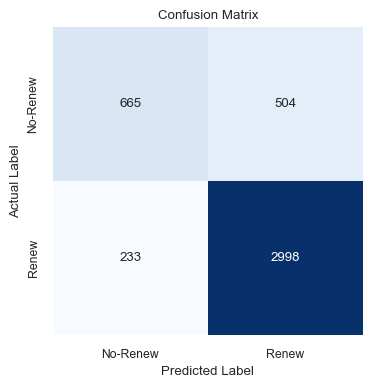

F1 Score: 0.6434446057087567
Precision: 0.7405345211581291
Recall: 0.5688622754491018
Accuracy: 0.8325
ROC AUC: 0.8954611006134701


In [38]:
rf_pred_train = tuned_rf_estimator.predict(imputed_train)
rf_pred_prob_train = tuned_rf_estimator.predict_proba(imputed_train)[:, 1]
print_metrics(y_train, rf_pred_train, rf_pred_prob_train)

#### Performance of Tuned Random Forest Classifier on Test Set

Confusion Matrix


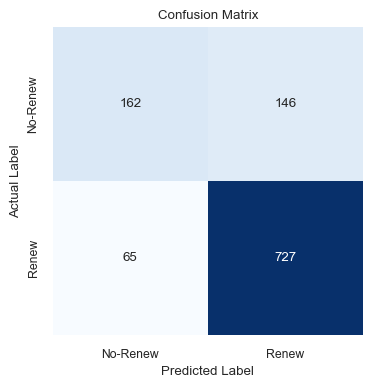

F1 Score: 0.6056074766355141
Precision: 0.7136563876651982
Recall: 0.525974025974026
Accuracy: 0.8081818181818182
ROC AUC: 0.8487759084349994


In [39]:
rf_pred_test = tuned_rf_estimator.predict(imputed_test)
rf_pred_prob_test = tuned_rf_estimator.predict_proba(imputed_test)[:, 1]
print_metrics(y_test, rf_pred_test, rf_pred_prob_test)

As the best random forest classifier from hyperparameter tuning has a slightly lower F1 score than the random forest classifier without tuning, I use the random forest classifier without tuning to identify the important factors that contribute to insurees not renewing in the interest of time. A different hyperparameter search space can be tried to tune the random forest classifier, but will require more time.

### Important Factors to Insurees Not Renewing

In [57]:
feature_labels = list(X_train.columns) + list(enc.get_feature_names_out())
df_feature_importance = pd.DataFrame(list(zip(feature_labels, rf_estimator.feature_importances_)), columns=['features', 'importance'])

In [58]:
df_feature_importance.sort_values(by=['importance'], ascending=False)

,features,importance
3,insuredMonths,0.193479
7,monthlyPremium,0.176717
4,healthInsurance,0.168079
6,eStatements,0.149446
13,healthRider3,0.077526
5,premiumFrequency,0.031533
15,healthInsurance_Class A,0.031132
0,is45OrOlder,0.024956
14,healthRider4,0.023097
8,totalPremium,0.017850


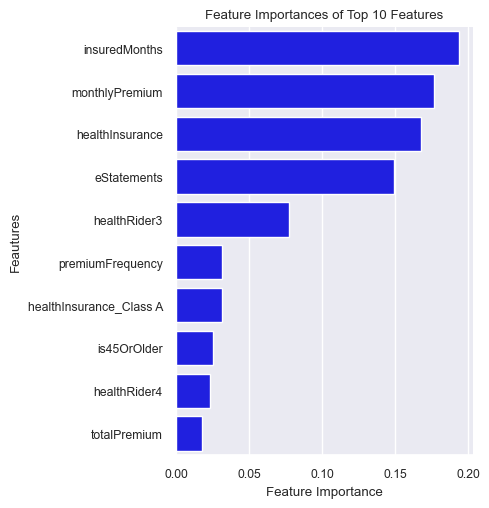

In [60]:
ax = sns.catplot(
    y = 'features',
    x = 'importance',
    data = df_feature_importance.sort_values(by=['importance'], ascending=False).head(10),
    kind='bar',
    color='blue'
)

ax.fig.gca().set_title("Feature Importances of Top 10 Features")
ax.fig.gca().set_ylabel("Feautures")
ax.fig.gca().set_xlabel("Feature Importance")
plt.show()

<b> Observation </b> 
* The top 3 most important features identified by the best Random Forest model are insuredMonths, monthlyPremium and healthInsurance. These are relatively important in contributing to why the insurees are not renewing as seen in the relatively higher feature importance, meaning that it decreases the impurity of the split of a node more on average over all trees in the random forest. 
* They can also be understood as the factors that influence an insuree's decision to renew their policy or not. For example, the amount of monthly premium can affect an insuree's choice to renew as they may or may not be willing to pay that amount. 
* Understanding these factors are important to the insurance company to target and retain insurees as it should strive for a high persistency ratio which will help to highlight the company's credibility as their insurance customers are willing to stick with them for such a long time. 